# Evolver Loop 1 Analysis

Analyze the baseline submission to identify:
1. Per-N score breakdown
2. Which N values have the most room for improvement
3. Compare with other available pre-optimized solutions

In [1]:
import os
import pandas as pd
import numpy as np
from shapely.geometry import Polygon
from shapely import affinity
from shapely.strtree import STRtree
import matplotlib.pyplot as plt

# Tree geometry
TX = [0, 0.125, 0.0625, 0.2, 0.1, 0.35, 0.075, 0.075, -0.075, -0.075, -0.35, -0.1, -0.2, -0.0625, -0.125]
TY = [0.8, 0.5, 0.5, 0.25, 0.25, 0, 0, -0.2, -0.2, 0, 0, 0.25, 0.25, 0.5, 0.5]

def get_tree_polygon(x, y, deg):
    """Create a Shapely polygon for a tree at (x, y) with rotation deg."""
    base_poly = Polygon(zip(TX, TY))
    rotated = affinity.rotate(base_poly, deg, origin=(0, 0))
    translated = affinity.translate(rotated, x, y)
    return translated

def load_trees_for_n(df, n):
    """Load trees for a specific N value from submission dataframe."""
    prefix = f'{n:03d}_'
    rows = df[df['id'].str.startswith(prefix)]
    trees = []
    for _, row in rows.iterrows():
        x = float(str(row['x']).replace('s', ''))
        y = float(str(row['y']).replace('s', ''))
        deg = float(str(row['deg']).replace('s', ''))
        trees.append((x, y, deg))
    return trees

def get_bounding_box_side(trees):
    """Calculate the side length of the bounding square for trees."""
    if not trees:
        return 0
    
    all_x = []
    all_y = []
    for x, y, deg in trees:
        poly = get_tree_polygon(x, y, deg)
        bounds = poly.bounds  # (minx, miny, maxx, maxy)
        all_x.extend([bounds[0], bounds[2]])
        all_y.extend([bounds[1], bounds[3]])
    
    width = max(all_x) - min(all_x)
    height = max(all_y) - min(all_y)
    return max(width, height)

def calculate_per_n_scores(df):
    """Calculate per-N scores for a submission."""
    per_n_scores = []
    for n in range(1, 201):
        trees = load_trees_for_n(df, n)
        side = get_bounding_box_side(trees)
        score = side**2 / n
        per_n_scores.append({'n': n, 'side': side, 'score': score})
    return pd.DataFrame(per_n_scores)

print('Functions defined!')

Functions defined!


In [2]:
# Load the baseline submission
baseline_path = '/home/code/experiments/001_baseline/santa-2025.csv'
df_baseline = pd.read_csv(baseline_path)
print(f'Loaded baseline with {len(df_baseline)} rows')

# Calculate per-N scores
print('Calculating per-N scores for baseline...')
baseline_scores = calculate_per_n_scores(df_baseline)
print(f'Total baseline score: {baseline_scores["score"].sum():.6f}')

Loaded baseline with 20100 rows
Calculating per-N scores for baseline...


Total baseline score: 70.676102


In [3]:
# Analyze per-N score distribution
print('Per-N Score Analysis:')
print('='*60)

# Top 20 contributors to total score
baseline_scores_sorted = baseline_scores.sort_values('score', ascending=False)
print('\nTop 20 N values by score contribution:')
for _, row in baseline_scores_sorted.head(20).iterrows():
    print(f"  N={int(row['n']):3d}: side={row['side']:.6f}, score={row['score']:.6f}")

# Cumulative contribution
baseline_scores['cumulative'] = baseline_scores['score'].cumsum()
baseline_scores['cumulative_pct'] = baseline_scores['cumulative'] / baseline_scores['score'].sum() * 100

print('\nCumulative contribution by N:')
for n in [10, 20, 30, 50, 100, 150, 200]:
    row = baseline_scores[baseline_scores['n'] == n].iloc[0]
    print(f"  N=1 to {n}: {row['cumulative']:.4f} ({row['cumulative_pct']:.1f}%)")

# Score per N (should decrease as N increases)
print('\nScore per N (first 20):')
for _, row in baseline_scores.head(20).iterrows():
    print(f"  N={int(row['n']):3d}: {row['score']:.6f}")

Per-N Score Analysis:

Top 20 N values by score contribution:
  N=  1: side=0.813173, score=0.661250
  N=  2: side=0.949504, score=0.450779
  N=  3: side=1.142031, score=0.434745
  N=  5: side=1.443692, score=0.416850
  N=  4: side=1.290806, score=0.416545
  N=  7: side=1.673104, score=0.399897
  N=  6: side=1.548438, score=0.399610
  N=  9: side=1.867280, score=0.387415
  N=  8: side=1.755921, score=0.385407
  N= 15: side=2.384962, score=0.379203
  N= 10: side=1.940696, score=0.376630
  N= 21: side=2.811667, score=0.376451
  N= 20: side=2.742469, score=0.376057
  N= 11: side=2.033002, score=0.375736
  N= 22: side=2.873270, score=0.375258
  N= 16: side=2.446640, score=0.374128
  N= 26: side=3.118320, score=0.373997
  N= 12: side=2.114873, score=0.372724
  N= 13: side=2.200046, score=0.372323
  N= 25: side=3.050182, score=0.372144

Cumulative contribution by N:
  N=1 to 10: 4.3291 (6.1%)
  N=1 to 20: 8.0573 (11.4%)
  N=1 to 30: 11.7462 (16.6%)
  N=1 to 50: 19.0422 (26.9%)
  N=1 to 100: 

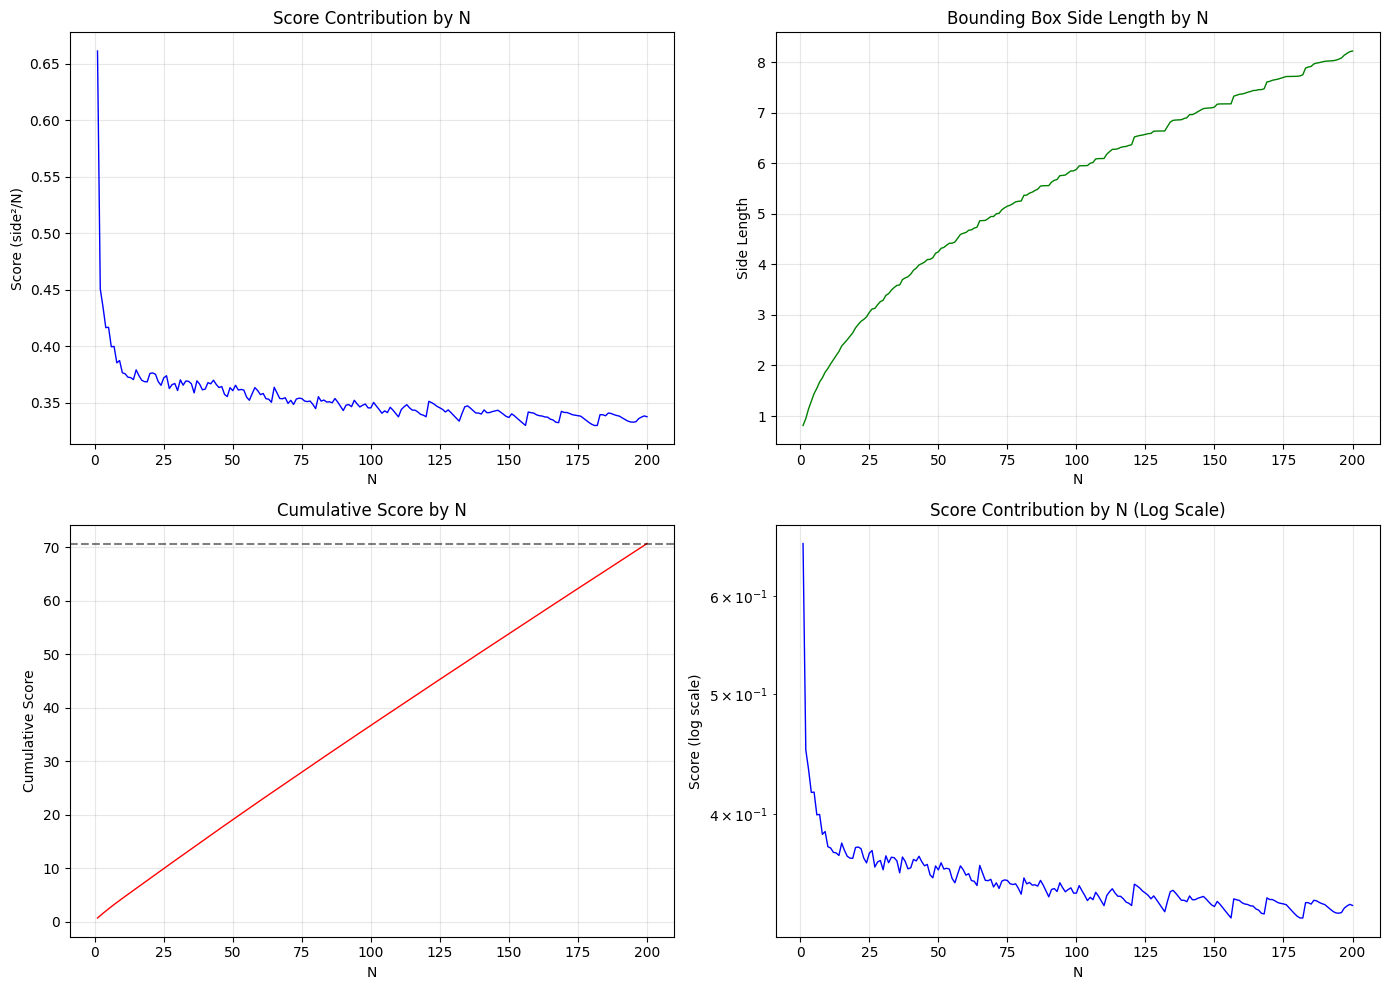

Saved plot to /home/code/exploration/per_n_analysis.png


In [4]:
# Plot per-N scores
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Score vs N
ax1 = axes[0, 0]
ax1.plot(baseline_scores['n'], baseline_scores['score'], 'b-', linewidth=1)
ax1.set_xlabel('N')
ax1.set_ylabel('Score (side²/N)')
ax1.set_title('Score Contribution by N')
ax1.grid(True, alpha=0.3)

# Side length vs N
ax2 = axes[0, 1]
ax2.plot(baseline_scores['n'], baseline_scores['side'], 'g-', linewidth=1)
ax2.set_xlabel('N')
ax2.set_ylabel('Side Length')
ax2.set_title('Bounding Box Side Length by N')
ax2.grid(True, alpha=0.3)

# Cumulative score
ax3 = axes[1, 0]
ax3.plot(baseline_scores['n'], baseline_scores['cumulative'], 'r-', linewidth=1)
ax3.axhline(y=baseline_scores['score'].sum(), color='k', linestyle='--', alpha=0.5)
ax3.set_xlabel('N')
ax3.set_ylabel('Cumulative Score')
ax3.set_title('Cumulative Score by N')
ax3.grid(True, alpha=0.3)

# Score per N (log scale)
ax4 = axes[1, 1]
ax4.semilogy(baseline_scores['n'], baseline_scores['score'], 'b-', linewidth=1)
ax4.set_xlabel('N')
ax4.set_ylabel('Score (log scale)')
ax4.set_title('Score Contribution by N (Log Scale)')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/home/code/exploration/per_n_analysis.png', dpi=150)
plt.show()
print('Saved plot to /home/code/exploration/per_n_analysis.png')

In [5]:
# Compare with other available pre-optimized solutions
print('Comparing with other pre-optimized solutions...')

other_solutions = [
    ('/home/nonroot/snapshots/santa-2025/21116303805/code/preoptimized/bucket-of-chump/submission.csv', 'bucket-of-chump'),
    ('/home/nonroot/snapshots/santa-2025/21116303805/code/preoptimized/santa25-public/submission_70_926149550346.csv', 'submission_70.92'),
    ('/home/nonroot/snapshots/santa-2025/21116303805/code/preoptimized/santa25-public/submission_70_936673758122.csv', 'submission_70.93'),
    ('/home/nonroot/snapshots/santa-2025/21116303805/code/preoptimized/telegram/71.97.csv', 'telegram_71.97'),
]

all_scores = {'baseline': baseline_scores}

for path, name in other_solutions:
    if os.path.exists(path):
        try:
            df = pd.read_csv(path)
            scores = calculate_per_n_scores(df)
            total = scores['score'].sum()
            all_scores[name] = scores
            print(f'{name}: {total:.6f}')
        except Exception as e:
            print(f'{name}: Error - {e}')
    else:
        print(f'{name}: File not found')

Comparing with other pre-optimized solutions...


bucket-of-chump: 70.676501


submission_70.92: 70.926150


submission_70.93: 70.936674


telegram_71.97: 71.972027


In [6]:
# Find N values where other solutions are better than baseline
print('\nN values where other solutions beat baseline:')
print('='*60)

for name, scores in all_scores.items():
    if name == 'baseline':
        continue
    
    better_n = []
    for n in range(1, 201):
        baseline_score = baseline_scores[baseline_scores['n'] == n]['score'].values[0]
        other_score = scores[scores['n'] == n]['score'].values[0]
        if other_score < baseline_score:
            improvement = baseline_score - other_score
            better_n.append((n, improvement))
    
    if better_n:
        print(f'\n{name}: {len(better_n)} N values are better')
        # Show top 10 improvements
        better_n.sort(key=lambda x: x[1], reverse=True)
        for n, imp in better_n[:10]:
            print(f'  N={n}: improvement = {imp:.6f}')


N values where other solutions beat baseline:


In [7]:
# Create an ensemble of best per-N configurations
print('Creating ensemble of best per-N configurations...')

best_per_n = {}
for n in range(1, 201):
    best_score = float('inf')
    best_source = None
    
    for name, scores in all_scores.items():
        score = scores[scores['n'] == n]['score'].values[0]
        if score < best_score:
            best_score = score
            best_source = name
    
    best_per_n[n] = {'score': best_score, 'source': best_source}

# Calculate ensemble score
ensemble_score = sum(v['score'] for v in best_per_n.values())
print(f'\nEnsemble score: {ensemble_score:.6f}')
print(f'Baseline score: {baseline_scores["score"].sum():.6f}')
print(f'Improvement: {baseline_scores["score"].sum() - ensemble_score:.6f}')

# Count sources
from collections import Counter
source_counts = Counter(v['source'] for v in best_per_n.values())
print('\nBest source counts:')
for source, count in source_counts.most_common():
    print(f'  {source}: {count} N values')

Creating ensemble of best per-N configurations...



Ensemble score: 70.676102
Baseline score: 70.676102
Improvement: -0.000000

Best source counts:
  baseline: 200 N values
